# Prediction with RNN

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Masking,Embedding,Bidirectional,TimeDistributed
#%tensorflow_version 2.x


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=None, val_df=None, test_df=None,
               label_columns=None, mean = 0, std = 1):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.mean = mean
        self.std = std

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label slice: {self.labels_slice}',
            f'Input Slice: {self.input_slice}',
            f'Label column name(s): {self.label_columns}'])
    
    def plot(self, model=None, plot_col='Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)', max_subplots=3):
        inputs, labels = self.example
        
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        plt.figure(figsize=(12, 3*max_n))

        inputs_denorm = (inputs*std)+mean
        labels_denorm = (labels*std[plot_col_index])+mean[plot_col_index]

        for n in range(max_n):
            plt.subplot(max_subplots, 1, n+1)
            #plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices/6, inputs_denorm[n, :, plot_col_index],
                     label='Inputs', c='#007bff')

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.plot(self.label_indices/6, labels_denorm[n, :, label_col_index], label='Labels', c='#ffc107')

            if model is not None:
                print((self.label_indices/6).shape)
                print((labels_denorm).shape)
                print(inputs.shape)
                predictions = model(inputs)
                predictions_denorm = (predictions*std[plot_col_index])+mean[plot_col_index]
                plt.plot(self.label_indices/6, predictions_denorm[n, :, label_col_index],
                          label='Predictions',
                          c='#dc3545')

            if n == 0:
                plt.legend()

            #plt.xticks(np.arange(0,48,2))

        
        plt.suptitle("Prediction of "+plot_col)
        plt.xlabel('Time [h]')
        plt.ylabel('Temperature [°C]')
        
   
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        result = next(iter(self.test))
    self._example = result
    return result


def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32)

  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Carico i dati da *eplusout.csv*

In [3]:

df1=pd.read_csv('https://raw.githubusercontent.com/bre3760/ictbuilding/dev/data/anno1/eplusout/eplusout.csv')
df2=pd.read_csv('https://raw.githubusercontent.com/bre3760/ictbuilding/dev/data/anno2/eplusout/eplusout.csv')
df3=pd.read_csv('https://raw.githubusercontent.com/bre3760/ictbuilding/dev/data/anno3/eplusout/eplusout.csv')
print(len(df1))

26352


In [4]:
def changetime(df,year):
    datetimeform= []
    for i in range(len(df.index)):
        tt = df["Date/Time"][i]
        days, hours = tt.split('  ')
        tt = f'{days.split("/")[1]}/{days.split("/")[0]}/{year}{hours}'
        tt = tt.replace(' ', '')
        if '201724:' or '201824:' or '201924:' in tt:
            tt=tt.replace('24:', '00:')
            timestamp = time.mktime(datetime.strptime(tt, "%d/%m/%Y%H:%M:%S").timetuple())
            timestamp += 86400
            #timestamp = datetime.fromtimestamp(timestamp)

        else:
            timestamp = time.mktime(datetime.strptime(tt, "%d/%m/%Y%H:%M:%S").timetuple())
            #timestamp = datetime.fromtimestamp(timestamp)
        datetimeform.append(timestamp)

    df["TimeStep"]=datetimeform
    
changetime(df1,"2017")
changetime(df2,"2018")
changetime(df3,"2019")
df1.head()

,Date/Time,Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),Environment:Site Outdoor Air Dewpoint Temperature [C](TimeStep),Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly),Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),Environment:Site Wind Speed [m/s](TimeStep),Environment:Site Wind Speed [m/s](Hourly),Environment:Site Wind Direction [deg](TimeStep),...,DistrictCooling:Facility [J](TimeStep),DistrictHeating:Facility [J](TimeStep),Carbon Equivalent:Facility [kg](TimeStep),BLOCK1:BEDROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:BEDROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),BLOCK1:BATHROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:BATHROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),BLOCK1:KITCHEN:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:KITCHEN:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),TimeStep
0,04/01 00:10:00,15.433333,NaN,10.3,NaN,101250.666667,NaN,3.0,NaN,19.166667,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491085e+09
1,04/01 00:20:00,14.366667,NaN,10.0,NaN,101280.333333,NaN,2.9,NaN,8.333333,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491085e+09
2,04/01 00:30:00,13.300000,NaN,9.7,NaN,101310.000000,NaN,2.8,NaN,357.500000,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491086e+09
3,04/01 00:40:00,12.233333,NaN,9.4,NaN,101339.666667,NaN,2.7,NaN,346.666667,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491086e+09
4,04/01 00:50:00,11.166667,NaN,9.1,NaN,101369.333333,NaN,2.6,NaN,335.833333,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491087e+09


In [5]:
# Extract mean temp time series
# mean value of the 3 indoor zones
def meanDF(df):
    df_mean = pd.DataFrame()
    #"Date/Time",\
    #"Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)",\
    #"Electricity:Facility [J](TimeStep)"
    df_mean = df[[
              "BLOCK1:BEDROOM:Zone Mean Air Temperature [C](TimeStep:ON)",\
              "BLOCK1:BATHROOM:Zone Mean Air Temperature [C](TimeStep:ON)",\
              "BLOCK1:KITCHEN:Zone Mean Air Temperature [C](TimeStep:ON)",\
              ]]
    df_temp=df_mean.copy()
    df_temp.dropna(inplace=True)
    df_temp["mean"] = df_temp.mean(1)


    df_final=pd.DataFrame()
    df_final["DateTime"] = df["TimeStep"]
    df_final["Outdoor_Mean"] = df["Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)"]
    df_final["Indoor_Mean"] = df_temp["mean"]
    df_final["Cooling"] = df["DistrictCooling:Facility [J](TimeStep)"]
    df_final["Power"]=df["Electricity:Facility [J](TimeStep)"]
    df_final["Delta_T"] = df_final["Indoor_Mean"]-df_final["Outdoor_Mean"]
    #df_final
    return df_final

df1_final=meanDF(df1)
df2_final=meanDF(df2)
df3_final=meanDF(df3)
df1_final.head()

,DateTime,Outdoor_Mean,Indoor_Mean,Cooling,Power,Delta_T
0,1.491085e+09,15.433333,24.517612,0.0,27449.355191,9.084278
1,1.491085e+09,14.366667,24.406119,0.0,27449.355191,10.039452
2,1.491086e+09,13.300000,24.285492,0.0,27449.355191,10.985492
3,1.491086e+09,12.233333,24.168972,0.0,27449.355191,11.935639
4,1.491087e+09,11.166667,24.055292,0.0,27449.355191,12.888626


In [6]:
# selecting only the values to train the rnn on 
x = pd.DataFrame()
meas = ["TimeStep","Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)",
        "Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep)",
        "Environment:Site Wind Speed [m/s](TimeStep)",
        "Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep)",
        "Environment:Site Wind Direction [deg](TimeStep)",
        "Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)"]

x["Indoor_Mean"] = pd.concat([df1_final["Indoor_Mean"],df2_final["Indoor_Mean"],df3_final["Indoor_Mean"]])
for m in meas:
    x[m]=pd.concat([df1[m],df2[m],df3[m]])
#x.set_index("TimeStep",inplace=True)
x.head()


,Indoor_Mean,TimeStep,Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),Environment:Site Wind Speed [m/s](TimeStep),Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),Environment:Site Wind Direction [deg](TimeStep),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)
0,24.517612,1.491085e+09,15.433333,0.0,3.0,101250.666667,19.166667,0.0
1,24.406119,1.491085e+09,14.366667,0.0,2.9,101280.333333,8.333333,0.0
2,24.285492,1.491086e+09,13.300000,0.0,2.8,101310.000000,357.500000,0.0
3,24.168972,1.491086e+09,12.233333,0.0,2.7,101339.666667,346.666667,0.0
4,24.055292,1.491087e+09,11.166667,0.0,2.6,101369.333333,335.833333,0.0


In [7]:
column_indices = {name: i for i, name in enumerate(x.columns)}
x.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Indoor_Mean,79056.0,2.569170e+01,5.149946e-01,2.190223e+01,2.545486e+01,2.600000e+01,2.600000e+01,2.666381e+01
TimeStep,79056.0,1.530525e+09,2.615061e+07,1.491084e+09,1.502942e+09,1.530525e+09,1.558108e+09,1.569967e+09
Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),79056.0,2.435966e+01,5.218590e+00,6.200000e+00,2.109583e+01,2.480000e+01,2.830000e+01,3.800000e+01
Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),79056.0,2.837174e+02,3.359258e+02,0.000000e+00,0.000000e+00,4.700000e+01,6.553333e+02,9.190000e+02
Environment:Site Wind Speed [m/s](TimeStep),79056.0,3.948260e+00,2.656548e+00,0.000000e+00,1.900000e+00,3.350000e+00,5.600000e+00,1.650000e+01
Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),79056.0,1.010223e+05,3.484209e+02,9.968200e+04,1.007928e+05,1.011000e+05,1.012970e+05,1.022000e+05
Environment:Site Wind Direction [deg](TimeStep),79056.0,2.097937e+02,8.884432e+01,0.000000e+00,1.716667e+02,2.166667e+02,2.800000e+02,3.598333e+02
Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep),79056.0,8.063162e+01,9.072162e+01,0.000000e+00,0.000000e+00,5.100000e+01,1.455000e+02,5.320000e+02


In [8]:
num_features = x.shape[1]
print(num_features)

8


## Split dataset into train, validation and test and normalize data

In [9]:
ntot = len(x)

#first two years for trainig 

x_train = x[:(len(df1)+len(df2))]
x_train.set_index("TimeStep",inplace=True)
mean = x_train.mean()
std = x_train.std()
x_train_norm = (x_train - mean)/std
print("Training set dimension: ",len(x_train))

x_val =  x[(len(df1)+len(df2)): (len(df1)+len(df2)) + int(0.5*len(df3)) ]
x_val.set_index("TimeStep",inplace=True)
x_val_norm = (x_val-mean)/std
print("Validation set dimension: ",len(x_val))

x_test =  x[(len(df1)+len(df2)) + int(0.5*len(df3)):]
x_test.set_index("TimeStep",inplace=True)
x_test_norm = (x_test-mean)/std
print("Test set dimension: ",len(x_test))

Training set dimension:  52704
Validation set dimension:  13176
Test set dimension:  13176


In [10]:
#column_to_predict = 'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'
column_to_predict_indoor = 'Indoor_Mean'
w_indoor = WindowGenerator(input_width=6*24, label_width=6*24, shift=6*24,
                     train_df=x_train_norm, val_df=x_val_norm, test_df=x_test_norm,
                     label_columns=[column_to_predict_indoor],
                     mean = mean, std = std)

In [11]:
column_to_predict_outdoor = 'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'
w_outdoor = WindowGenerator(input_width=6*24, label_width=6*24, shift=6*24,
                     train_df=x_train_norm, val_df=x_val_norm, test_df=x_test_norm,
                     label_columns=[column_to_predict_outdoor],
                     mean = mean, std = std)

In [12]:
column_to_predict_outdoor_wide = 'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'
w_outdoor_wide = WindowGenerator(input_width=6*24*7, label_width=6*24*2, shift=6*24,
                     train_df=x_train_norm, val_df=x_val_norm, test_df=x_test_norm,
                     label_columns=[column_to_predict_outdoor_wide],
                     mean = mean, std = std)

In [13]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping],
                      batch_size=32)
    return history

In [14]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(144, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(6*24*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([6*24, num_features])
])


In [15]:
#history = compile_and_fit(multi_lstm_model, w_indoor)
history = compile_and_fit(multi_lstm_model, w_outdoor)

IPython.display.clear_output()
val_performance = {}
val_performance['LSTM'] = multi_lstm_model.evaluate(w_outdoor.val)
performance={}
performance['LSTM'] = multi_lstm_model.evaluate(w_outdoor.test, verbose=0)

403/403 [==============================] - 30s 74ms/step - loss: 0.1512 - mean_absolute_error: 0.2835


(144,)
(32, 144, 1)
(32, 144, 7)
(144,)
(32, 144, 1)
(32, 144, 7)
(144,)
(32, 144, 1)
(32, 144, 7)


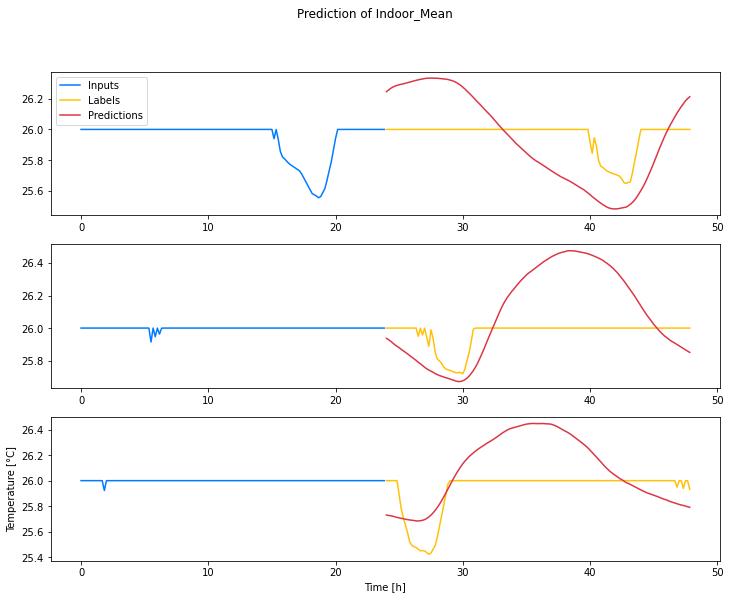

In [16]:
w_indoor.plot(multi_lstm_model, plot_col = column_to_predict_indoor, max_subplots=3)

(144,)
(32, 144, 1)
(32, 144, 7)
(144,)
(32, 144, 1)
(32, 144, 7)
(144,)
(32, 144, 1)
(32, 144, 7)


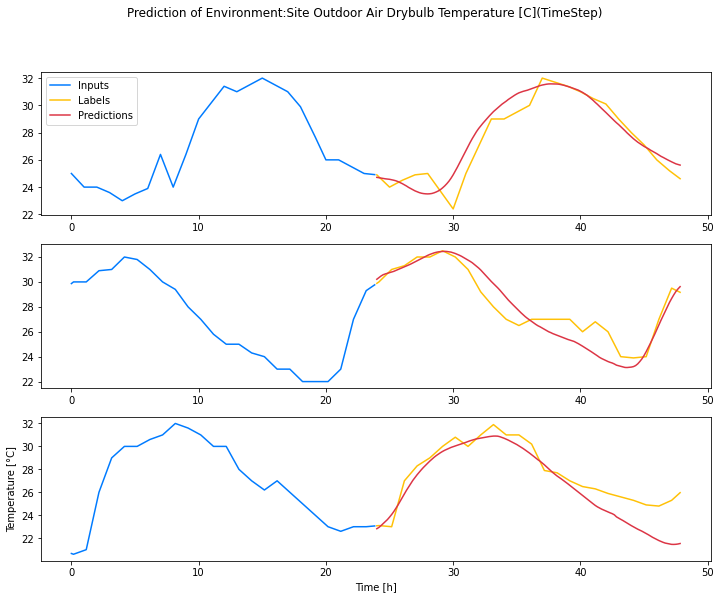

In [17]:

w_outdoor.plot(multi_lstm_model, plot_col = column_to_predict_outdoor,max_subplots=3)

(288,)
(32, 288, 1)
(32, 1008, 7)


ValueError: x and y must have same first dimension, but have shapes (288,) and (144,)

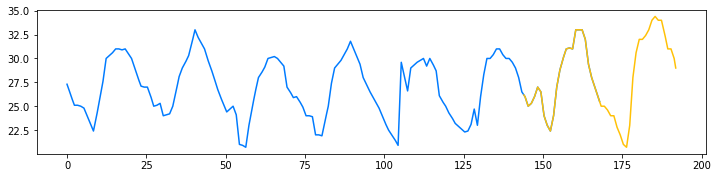

In [18]:
w_outdoor_wide.plot(multi_lstm_model, plot_col = column_to_predict_outdoor_wide, max_subplots=3)